In [48]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use("bmh")
import matplotlib_inline
if "NUMPYRO_SPHINXBUILD" in os.environ:
    #set_matplotlib_formats("svg")
    matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
plt.rcParams["text.usetex"] = False #True
import time
import collections
import multiprocessing
import random

### THIS MUST OCCUR BEFORE JAX IS IMPORTED ###
# for parallelization for multiple chains. Must be done before jax import:
# Blackjax tutorial: https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)
    
from src.models import unroll_dpg, dpg_bnn
from src.utils import adj2vec, vec2adj
from experiments.scaling.config import experiment_settings
from experiments.scaling.create_scaling_datasets import diag_embed
from src.utils import edge_density, degrees_from_upper_tri
from src.config import w_init_scale, lam_init_scale, altered_prior
from src.metrics import compute_metrics
from src import NUM_BINS, FIGURES_PATH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load the datasets
try:
    graph_sizes, adjacencies, euclidean_distances = [], [], []
    with open(experiment_settings['data_path'], 'rb') as handle:
        print(f'loading datasets from {experiment_settings["data_path"]}. Num Vertices: ', end='')
        datasets = pickle.load(handle)
        for n, d in datasets.items():
            print(f'{n}, ', end='')
            graph_sizes.append(n)
            adjacencies.append(d['adjacencies'])
            euclidean_distances.append(d['euclidean_distances'])
except:
    print(f"Scaling datasets not found at {experiment_settings['data_path']}. Sampling and saving. Can take a while as we sample large graphs.")

loading datasets from /Users/maxw/projects/gsl-bnn/data/scaling/datasets.pkl. Num Vertices: 10, 15, 20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 250, 300, 400, 500, 1000, 

## Analysis of the Sampled Scaling Datasets
 Note the strange behaviour where large ER graph becomes smoother

Basic Network Statistics of the Sampled Adjacencies
N = 10: mean edge density 0.28, mean number connected components 1.00
N = 15: mean edge density 0.26, mean number connected components 1.00
N = 20: mean edge density 0.25, mean number connected components 1.00
N = 30: mean edge density 0.25, mean number connected components 1.00
N = 40: mean edge density 0.25, mean number connected components 1.00
N = 50: mean edge density 0.25, mean number connected components 1.00
N = 60: mean edge density 0.25, mean number connected components 1.00
N = 80: mean edge density 0.25, mean number connected components 1.00
N = 100: mean edge density 0.25, mean number connected components 1.00
N = 120: mean edge density 0.25, mean number connected components 1.00
N = 150: mean edge density 0.25, mean number connected components 1.00
N = 200: mean edge density 0.25, mean number connected components 1.00
N = 250: mean edge density 0.25, mean number connected components 1.00
N = 300: mean edge density 0.25, 

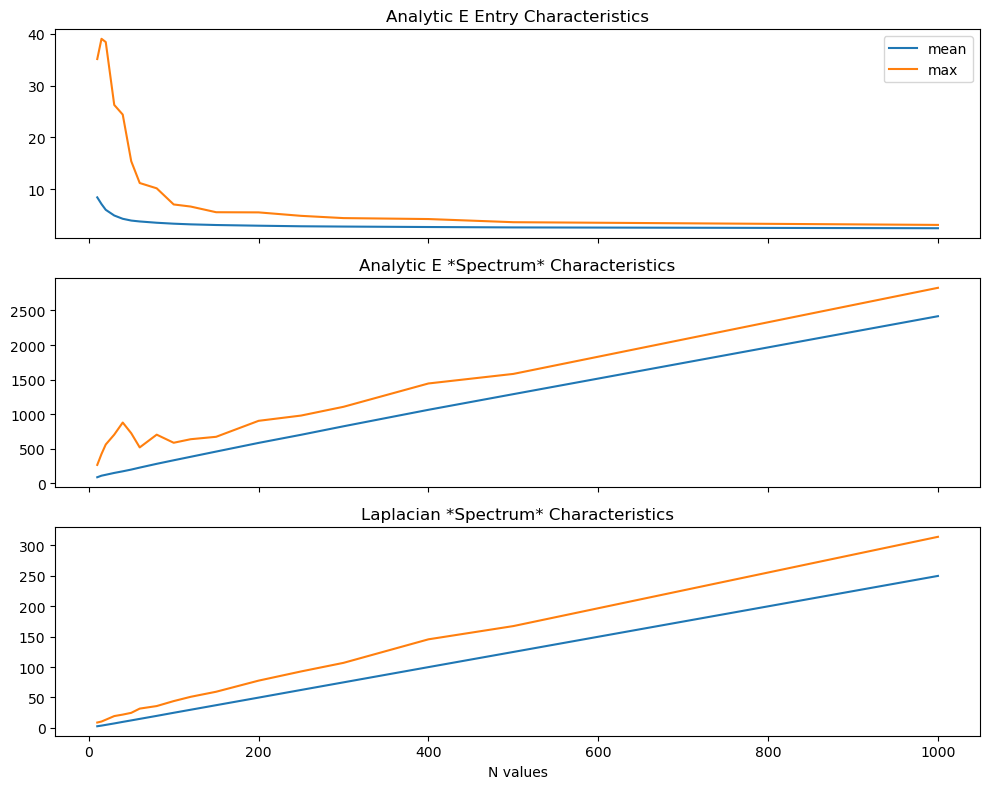

In [3]:
from src.utils import count_connected_components
import numpy as np

raw_data = {'mean': [], 'max': []}
laplacians_data = {'mean': [], 'max': []}
analytic_data = {'mean': [], 'max': []}

print(f'Basic Network Statistics of the Sampled Adjacencies')
for n, a, e in zip(graph_sizes, adjacencies, euclidean_distances):
    d = edge_density(a)
    num_cc = count_connected_components(a)
    print(f'N = {n}: mean edge density {d.mean():.2f}, mean number connected components {num_cc.mean():.2f}')

print(f'\nCharacteristics of the Raw Entries in the Analytic Euclidean Distances.')
for n, a, e in zip(graph_sizes, adjacencies, euclidean_distances):
    print(f'N = {n}: min {e.min():.2f}, mean {e.mean():.2f}, median {np.median(e):.2f}, max {e.max():.2f}')
    raw_data['mean'].append(e.mean())
    raw_data['max'].append(e.max())

print(f'\nEigenvalue Characteristics of the (un-normalize) Laplacians.')
for n, a, e in zip(graph_sizes, adjacencies, euclidean_distances):
    D = diag_embed(np.sum(a, axis=1))
    laplacians = D - a.astype(np.float32)
    eigvals = np.linalg.eigvalsh(laplacians)
    print(f'N = {n}: min {np.abs(eigvals.min()):.2f}, mean {eigvals.mean():.2f}, median {np.median(eigvals):.2f}, max {eigvals.max():.2f}, frac(max)(mean) {eigvals.max()/eigvals.mean():.2f}')
    laplacians_data['mean'].append(eigvals.mean())
    laplacians_data['max'].append(eigvals.max())

print(f'\nEigenvalue Characteristics of the Analytic Euclidean Distances.')
for n, a, e in zip(graph_sizes, adjacencies, euclidean_distances):
    D = diag_embed(np.sum(e, axis=1))
    laplacians = D - e.astype(np.float32)
    eigvals = np.linalg.eigvalsh(laplacians)
    print(f'N = {n}: min {np.abs(eigvals.min()):.2f}, mean {eigvals.mean():.2f}, median {np.median(eigvals):.2f}, max {eigvals.max():.2f}, frac(max)(mean) {eigvals.max()/eigvals.mean():.2f}')
    analytic_data['mean'].append(eigvals.mean())
    analytic_data['max'].append(eigvals.max())
    
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plotting
for idx, (dataset, title) in enumerate(zip([raw_data, analytic_data, laplacians_data], 
                                           ['Analytic E Entry Characteristics', 'Analytic E *Spectrum* Characteristics', 'Laplacian *Spectrum* Characteristics'])):
    for key in dataset:
        axs[idx].plot(graph_sizes, dataset[key], label=key)
    axs[idx].set_title(title)

# Only draw the legend on the first plot
axs[0].legend(loc='best')

plt.xlabel('N values')
plt.tight_layout()
plt.show()


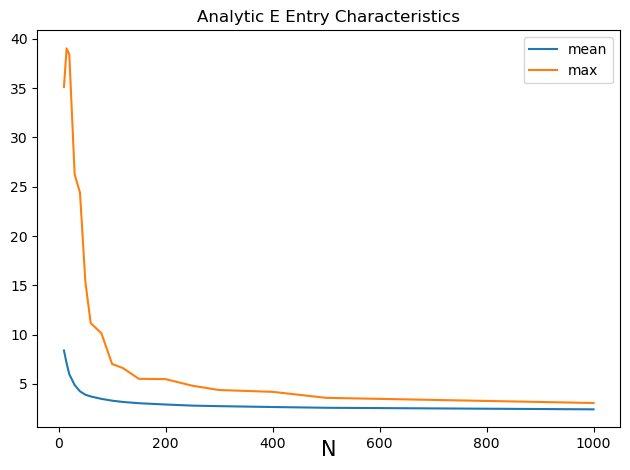

In [4]:
fig, axs = plt.subplots(1, 1, sharex=True)

for key in raw_data:
        axs.plot(graph_sizes, raw_data[key], label=key)
axs.legend(loc='best')
axs.set_title('Analytic E Entry Characteristics')
#plt.xlabel('N')
axs.set_xlabel('N', labelpad=-8, fontsize=15)
plt.tight_layout()
plt.show()

### Optional: Display a few Raw Adj/Euclidean Distance pairs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_matrices(euclidean_distances, adjacencies, indxs):
    n = len(indxs)

    fig = plt.figure(figsize=(12, n*5))
    gs = GridSpec(n, 3, width_ratios=[1, 1, 0.05])

    # Set a single colorbar for the Euclidean distance matrices
    norm = plt.Normalize(vmin=euclidean_distances.min(), vmax=euclidean_distances.max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    for i, indx in enumerate(indxs):
        # Get the size of the current graph
        graph_size = adjacencies[indx].shape[0]

        # Binary adjacency matrix
        ax0 = plt.subplot(gs[i, 0])
        ax0.imshow(adjacencies[indx], cmap='binary')
        ax0.set_title(f'Adjacency Matrix {indx} (Graph Size: {graph_size})')
        ax0.set_xticks([])
        ax0.set_yticks([])
        
        # Euclidean distance matrix
        ax1 = plt.subplot(gs[i, 1])
        ax1.imshow(euclidean_distances[indx], cmap='viridis')
        ax1.set_title(f'Euclidean Distance Matrix {indx} (Graph Size: {graph_size})')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Colorbar for the Euclidean distance matrices
        ax2 = plt.subplot(gs[i, 2])
        plt.colorbar(sm, cax=ax2, orientation='vertical')

    fig.suptitle(f'N = {euclidean_distances.shape[1]}')
    plt.show()


# Given your euclidean_distances, adjacencies, and indxs:
for n, a, e in zip(graph_sizes, adjacencies, euclidean_distances):
    plot_matrices(e, a, [0, 1, 2])


# Exploratory Analysis of Parameter Scaling Behaviour in The Convergent Setting
(Failed) attempts to determine analytical relationships between optimal parameter values as a function of graph size in the convergent setting.
- How should optimal \theta, \delta, b vary with graph size? 
- How does output edge weights (pre-\delta scaling) vary with optimal \theta at each graph size?

## Initialize and load data if already run

In [7]:
# precompute needed datastructures
Ss = {n: jnp.array(degrees_from_upper_tri(n)) for n in graph_sizes}

print(f'Computing D matrices...')
for n in graph_sizes:
    print('\t', Ss[n].shape, '--> expected edge set size: ', n*(n-1)//2)

Computing D matrices...
	 (10, 45) --> expected edge set size:  45
	 (15, 105) --> expected edge set size:  105
	 (20, 190) --> expected edge set size:  190
	 (30, 435) --> expected edge set size:  435
	 (40, 780) --> expected edge set size:  780
	 (50, 1225) --> expected edge set size:  1225
	 (60, 1770) --> expected edge set size:  1770
	 (80, 3160) --> expected edge set size:  3160
	 (100, 4950) --> expected edge set size:  4950
	 (120, 7140) --> expected edge set size:  7140
	 (150, 11175) --> expected edge set size:  11175
	 (200, 19900) --> expected edge set size:  19900
	 (250, 31125) --> expected edge set size:  31125
	 (300, 44850) --> expected edge set size:  44850
	 (400, 79800) --> expected edge set size:  79800
	 (500, 124750) --> expected edge set size:  124750
	 (1000, 499500) --> expected edge set size:  499500


## Grid Search over \Theta for each Graph Size N
\Theta^*(N) \sim \sqrt(N) ?

In [8]:
def calculate_scores(y_true, y_pred, eps=1e-3):
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred > eps)
    assert y_true.shape == y_pred.shape, f'compute_scores recieved incompatible shapes'

    # true positive
    TP = np.sum((y_pred == 1) & (y_true == 1), axis=1)
    # true negatives
    TN = np.sum((y_pred == 0) & (y_true == 0), axis=1)
    # false positives
    FP = np.sum((y_pred == 1) & (y_true == 0), axis=1)
    # false negatives
    FN = np.sum((y_pred == 0) & (y_true == 1), axis=1)

    # false positive rate
    FPR = FP / (FP + TN)
    # false negative rate
    FNR = FN / (FN + TP)
    # precision
    precision = TP / (TP + FP)
    # recall
    recall = TP / (TP + FN)
    # F1 score
    F1 = 2 * ((precision * recall) / (precision + recall))
    # Error Rate
    error = (FP + FN) / (TP + FP + TN + FN)

    return FPR, FNR, F1, error

### Run DPG to convergence for each graph size/theta pair

In [13]:
# define the search space for \theta
# for ER_{p=.25}(N), we know apriori that \theta^*:
# \theta^* (10) ~= .368
# \theta^* (20) ~= .368
# \theta^* (40) ~= .453
# \theta^* (50) ~= .495
# \theta^* (60) ~= .495
# \theta^* (80) ~= .537
# \theta^* (100) ~= .537
# \theta^* (150) ~= .55
thetas = np.linspace(.2, .8, 30)
depth = 10**4
threshold = 1e-3
performance = collections.defaultdict(dict)


# cache results
performance_file = 'er_p25_dpg_size_gen_investigation_converg_iters.pkl'
import pickle
with open(experiment_settings['results_path'] + performance_file, 'rb') as f:
    performance = pickle.load(f)
print(performance.keys())
graph_size_to_inspect = [15, 20, 50, 80, 100]
for n, d in datasets.items():
    if n in performance:
        print(f"Graph size {n} already computed. Skipping...")
        continue
    if n not in graph_size_to_inspect:
        continue
    a, e = d['adjacencies'], d['euclidean_distances']
    print(f'graph size: {n}')
    graph_size_start_time = time.time()

    a, e, = adj2vec(a), adj2vec(e)
    S, num_edges, experiment_settings['num_train_samples'] = Ss[n], n*(n-1)//2, len(a)
    w_init, lam_init = w_init_scale * jnp.ones((experiment_settings['num_train_samples'], num_edges)), lam_init_scale * jnp.ones((experiment_settings['num_train_samples'], n))
    w, lam = None, None

    for i, theta in enumerate(thetas):
        theta_start_time = time.time()
        print(f'\t{i+1}/{len(thetas)}: theta = {theta:.3f}')
        w, lam = unroll_dpg(
            x=e,
            w_init=w_init if w is None else w,
            lam_init=lam_init if lam is None else lam,
            theta=theta,
            num_steps=depth,
            S=S)
        FPR, FNR, F1, error = calculate_scores(a, w, eps=threshold)
        ed = edge_density(w>threshold)
        performance[n][theta] = {'FPR': FPR, 'FNR': FNR, 'F1': F1, 'error': error, 'edge_density': ed}
        print(f'\t\ttime {time.time() - theta_start_time:.3f} | edge density {ed.mean()*100:.2f} %, error {error.mean()*100:.1f} %, F1 {F1.mean()*100:.3f} %, FPR {FPR.mean()*100:.3f} %, FNR {FNR.mean()*100:.3f} %')
    print(f'graph size {n} took {time.time() - graph_size_start_time:.3f} s')
""" 
import pickle
with open(performance_file, 'wb') as f:
    pickle.dump(performance, f)
"""

dict_keys([15, 20, 50, 80, 100])
Graph size 15 already computed. Skipping...
Graph size 20 already computed. Skipping...
Graph size 50 already computed. Skipping...
Graph size 80 already computed. Skipping...
Graph size 100 already computed. Skipping...


" \nimport pickle\nwith open(performance_file, 'wb') as f:\n    pickle.dump(performance, f)\n"

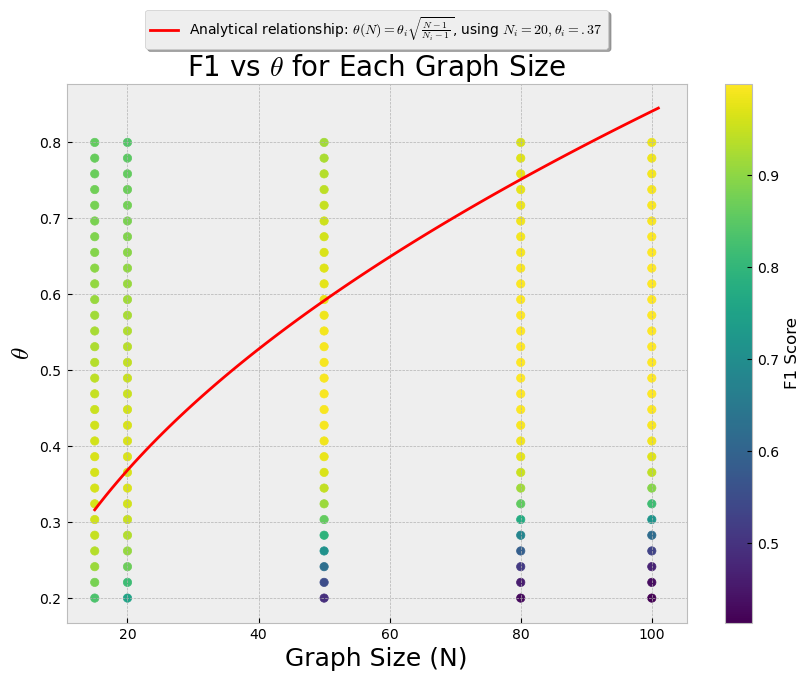

In [52]:
# Initialize lists to store graph sizes, optimal theta values, and max F1 scores
optimal_thetas = []
max_f1_scores = []
min_f1_scores = []
graph_sizes_list = []
thetas_list = []
f1_scores = []

# Get graph sizes in sorted order
graph_sizes = sorted(performance.keys())

# For each graph size, find theta that gives max F1 score
for size in performance.keys():
    # Extract F1 scores for this graph size for all theta values
    graph_sizes_list.extend([size]*len(thetas))
    thetas_list.extend(thetas)
    f1_scores.extend([performance[size][theta]['F1'].mean() for theta in thetas])
    #f1_scores = {theta: performance[size][theta]['F1'].mean() for theta in thetas}


# Convert F1 scores to color
cmap = plt.get_cmap('viridis')
#norm = plt.Normalize(min(f1_scores), 100)
#colors = cmap(norm(f1_scores))

# Create scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(graph_sizes_list, thetas_list, c=f1_scores)
#scatter = plt.scatter(graph_sizes_list, optimal_thetas, c=colors)

# Set the initial conditions for theta and N
N_i = 80
theta_i = 0.5368421052631579
#N_i = 50
#theta_i = 0.49473684210526314
N_i = 20
theta_i = 0.368421052631579


# Define the function to be overlaid
def theta_func(N, N_i, theta_i):
    return np.sqrt((N-1)/(N_i-1))*theta_i

# Generate y-values for each graph size
ns = [k for k in performance.keys()]
ns = np.linspace(min(ns), max(ns)+1, 100)
y_values = [theta_func(N, N_i, theta_i) for N in ns]#, performance.keys().max())] #graph_sizes]

# Add the overlay function to the plot
plt.plot(ns, y_values, 'r', label=r'Analytical relationship: $\theta(N) = \theta_i \sqrt{\frac{N-1}{N_i-1}}$, using $N_i=20, \theta_i=.37$') # N_i={N_i}, theta_i = {theta_i:.3f}')
#plt.plot(graph_sizes, y_values, 'r', label=r'Analytical relationship: $\theta$(N) = \sqrt{\frac{{N-1}{N_i-1}} * \theta_i$') #, N_i={N_i}, theta_i = {theta_i:.3f}')

# Add title, x and y labels, and legend
plt.title(r'F1 vs $\theta$ for Each Graph Size', fontsize=20)
plt.xlabel(r'Graph Size (N)', fontsize=18)
plt.ylabel(r'$\theta$', fontsize=18)
plt.legend(fontsize=13)
# make legend on top, but below title, make it span the whole axes
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fancybox=True, shadow=True) # this is above the title
# ensure it it below the title, it should not be the same as the command above this line



# set x as log scales
#plt.xscale('log')

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('F1 Score')

plt.grid(True)
plt.show()

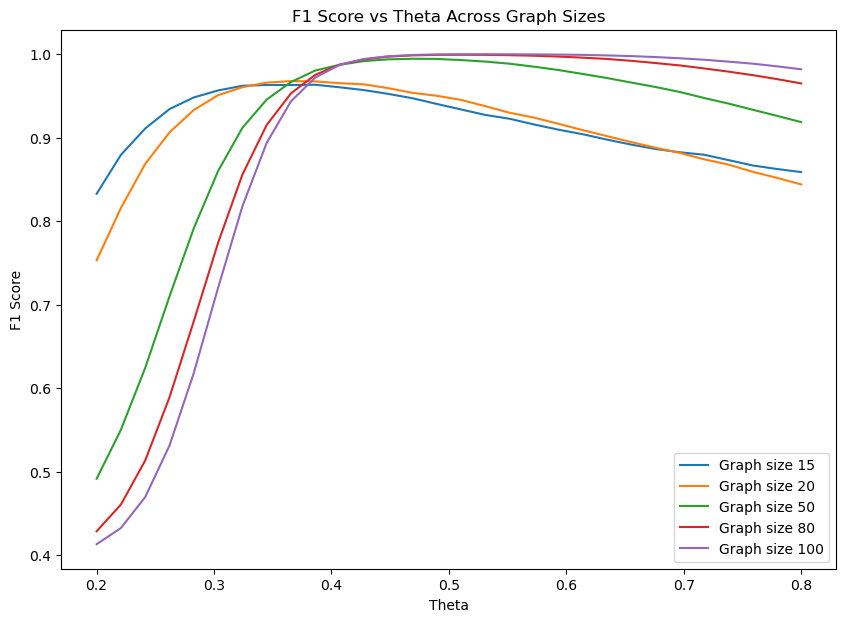

In [18]:
# Create a new figure
plt.figure(figsize=(10, 7))

# Iterate over each graph size
for size in performance.keys():
    # Retrieve theta values and corresponding F1 scores
    thetas = sorted(performance[size].keys())
    f1_scores = [performance[size][theta]['F1'].mean() for theta in thetas]
    
    # Plot theta vs F1 score for this graph size
    plt.plot(thetas, f1_scores, label=f'Graph size {size}')

# Add labels, title and legend
plt.xlabel('Theta')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Theta Across Graph Sizes')
plt.legend()

# Show the plot
plt.show()

### Edge Weight distribution (@ optimal theta) vs N

In [24]:
# plot edge weight distributions
# Optimal theta vs graph size. Fit

#  these are thetas found to be pretty good (~= 0 error)
optimal_thetas = {
    15: .345,
    20: .366,
    50: .469,
    80: .510,
    100: .531,
    #150: 
    }
optimal_points = {n: {} for n in optimal_thetas.keys()}
depth = 5*10**4 # <--- really be sure about convergence
threshold = 1e-3

for n in performance.keys():
    print(f'graph size: {n}')
    d = datasets[n]
    a, e = d['adjacencies'], d['euclidean_distances']
    a, e, = adj2vec(a), adj2vec(e)
    S, num_edges = Ss[n], n*(n-1)//2
    w_init, lam_init = w_init_scale * jnp.ones((len(a), num_edges)), lam_init_scale * jnp.ones((len(a), n))
    w, lam = None, None
    theta = optimal_thetas[n]
    theta_start_time = time.time()
    w, lam = unroll_dpg(
        x=e,
        w_init=w_init if w is None else w,
        lam_init=lam_init if lam is None else lam,
        theta=optimal_thetas[n],
        num_steps=depth,
        S=S)
    optimal_points[n] = {'w': w, 'lam': lam}
    print(f'\ttime {time.time() - theta_start_time:.3f}')

graph size: 15
	time 0.750
graph size: 20
	time 1.509
graph size: 50
	time 8.786
graph size: 80
	time 26.534
graph size: 100
	time 43.339


### let's visualize what the distribution of optimal w, lam values are for each graph size

N: [15, 20, 50, 80, 100]
mean w: [0.04262391 0.03190534 0.01216019 0.00752296 0.00600484]
mean lam: [1.9096904 1.9021722 1.781262  1.7514925 1.7345699]


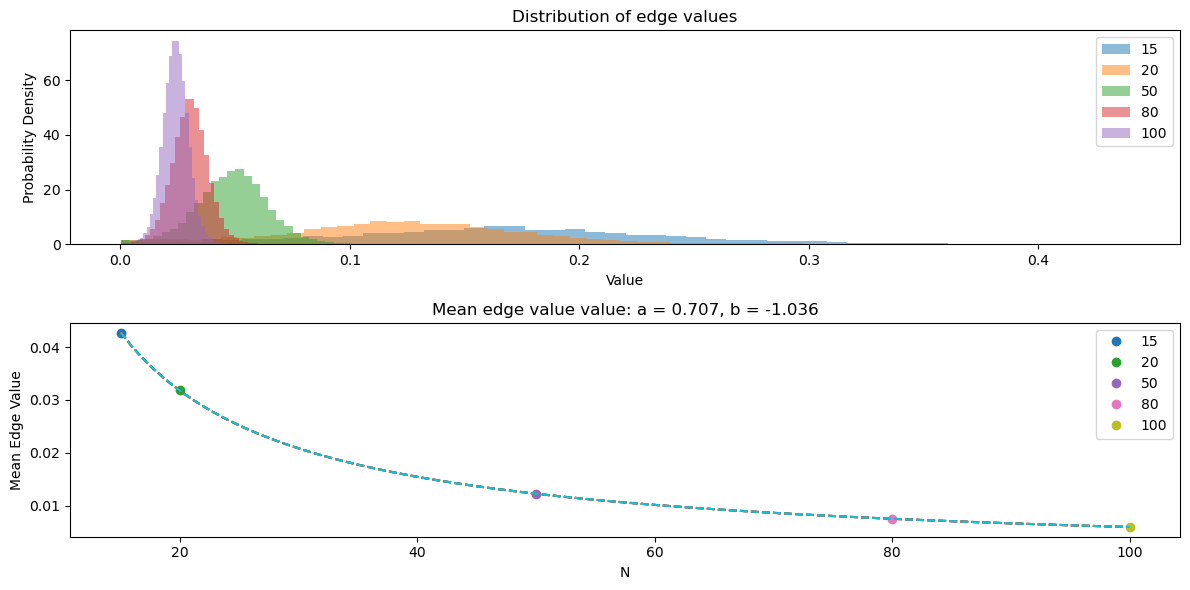

In [26]:
def plot_distributions(optimal_points, zero_threshold=1e-4):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))

    # fit line to log scaled data
    w_mean = np.array([value['w'].mean() for value in optimal_points.values()])
    lam_mean = np.array([value['lam'].mean() for value in optimal_points.values()])
    print(f'N: {list(optimal_points.keys())}')
    print(f'mean w: {w_mean}')
    print(f'mean lam: {lam_mean}')
    
    # Define the power law function
    def power_law(N, a, b):
        return a * np.power(N, b)

    # Fit the power law to the data
    params, _ = curve_fit(power_law, graph_sizes, w_mean)

    # Extract the fitted parameters
    a, b = params

    # Generate interpolated N values
    interpolated_N = np.linspace(graph_sizes[0], graph_sizes[-1], 100)

    # Predict mean w using the fitted power law
    predicted_mean_w = power_law(interpolated_N, a, b)

    # loop over each key-value pair in optimal_points
    for key, value in optimal_points.items():
        w, lam = value['w'], value['lam']

        # calculate percentage of exact zeros in w
        zero_percentage_w = np.sum(w <= zero_threshold) / w.size * 100

        # create histogram of non-zero w values
        axs[0].hist(w[w > zero_threshold], bins=50, density=True, alpha=0.5, label=f'{key}')# (%0.0f%% zeros)' % zero_percentage_w)
        # mean w
        axs[1].plot(key, w.mean(), 'o', label=f'{key}')
        #axs[1].set_xscale('log')
        #axs[1].set_yscale('log')
        # when the x axis is log scaled, it looks linear. Fit a line and plot it over the points.
        axs[1].plot(interpolated_N, predicted_mean_w, '--')
    
    # add a power law line in axs[0]
    #axs[0].plot(interpolated_N, power_law(interpolated_N, a, b), '--', label='power law fit')

    # set titles, legend and other aesthetics
    axs[0].set_title('Distribution of edge values')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Probability Density')
    axs[0].legend()
    axs[1].set_title('Mean edge value value: a = {:.3f}, b = {:.3f}'.format(a, b))
    axs[1].set_xlabel('N')
    axs[1].set_ylabel('Mean Edge Value')
    axs[1].legend()


    plt.tight_layout()
    plt.show()

plot_distributions(optimal_points)

# Derive Empirical Estimate of Parameter Growth Trend: MAP Estimate vs Graph Size

In [ ]:
""" Find MAP estimates """
#sys.path.append('/content/bayes_gsl') # for colab
map_params = collections.defaultdict(dict) if 'map_params' not in locals() else map_params

### Train MAP models

In [44]:
train_map_models = False

In [45]:
if train_map_models:
    for n in experiment_settings['map_graph_sizes_to_train']: #[20, 50, 80, 100, 150, 200, 300]:
        if n in map_params:
            continue
        print(f"Graph size {n} with {experiment_settings['map_num_train_samples']} samples")
        a, e = datasets[n]['adjacencies'], datasets[n]['euclidean_distances']
        a, e, = adj2vec(a), adj2vec(e)
        a_train, e_train = a[:experiment_settings['map_num_train_samples']], e[:experiment_settings['map_num_train_samples']]
        num_edges = n*(n-1)//2
        S = Ss[n]

        ### configure model
        max_likelihood = False
        # initialize inputs
        w_init, lam_init = w_init_scale * jnp.ones((experiment_settings['map_num_train_samples'], num_edges)), lam_init_scale * jnp.ones((experiment_settings['map_num_train_samples'], n))

        model_args = {'x': e_train, 'y': a_train,
                    'depth': experiment_settings['map_dpg_depth'],
                    'w_init': w_init, 'lam_init': lam_init,
                    'S': S,
                    'prior_settings': altered_prior()} # priors still required for MAP estimate
        # print name and shape
        #print('x:', model_args['x'].shape, 'y:', model_args['y'].shape, 'w_init: ', model_args['w_init'].shape, 'lam_init: ', model_args['lam_init'].shape, 'D: ', model_args['D'].shape)

        # train model
        def run_svi(model, guide_family, model_args, optim_args):
            if guide_family == "AutoDelta":
                guide = autoguide.AutoDelta(model)
            elif guide_family == "AutoDiagonalNormal":
                guide = autoguide.AutoDiagonalNormal(model)
            else:
                raise ValueError("Invalid guide family")

            optimizer = numpyro.optim.Adam(optim_args['learning_rate'])
            svi = SVI(model, guide, optimizer, Trace_ELBO())
            print(model_args.keys())
            svi_results = svi.run(PRNGKey(1), optim_args['maxiter'], **model_args)
            params = svi_results.params

            return params, guide

        random.seed(experiment_settings['random_seed'])
        np.random.seed(experiment_settings['random_seed'])

        model = dpg_bnn.model
        params, map_guide = \
            run_svi(model, 
                    "AutoDelta", 
                    model_args, 
                    {'maxiter': experiment_settings['maxiter'], ### THIS WILL NEED TO BE INCREASED BEYOND 5k FOR CONVERGENCE ON ALL MODELS. E.g. N=200 Loss still decreasing beyond 7500
                    'learning_rate': experiment_settings['learning_rate']})

        # display results
        print(f"Graph Size {n}: MAP estimates theta {params['theta_auto_loc']}, delta {params['delta_auto_loc']}, b {params['b_auto_loc']}")
        print(params)
        map_params[n] = params

Example showing MAP estimates havent quite converged for N=200
200:
- 1000 iters = 120.719 loss
- 1500 iters = 45.9 loss
- 2000 iters = 29.7 loss
- 3700 iters = 19.5 loss
- 4500 iters = 17.9 loss
- 7500 iters = 17.5 loss

## Visualize Emprical Trends of MAP Parameter estimates vs Graph Size

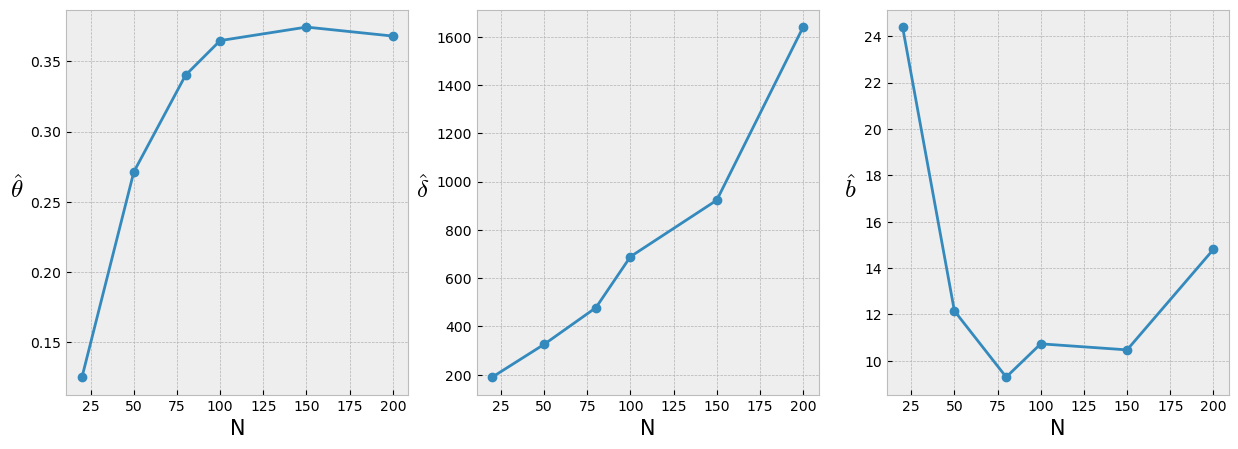

[-3.07620888e-02  9.26606896e-03 -7.84438519e-05  2.93676236e-07
 -4.16393360e-10] [  7.75923599 -68.53748473] [105.29748968  -0.45610003]


<Figure size 640x480 with 0 Axes>

In [49]:
# found using 10 samples, depth = 200
# ran until moderate convergence. Loss still going down a bit though.
map_params = {
    20: {'theta': 0.12531666, 'delta': 189.77264404296875, 'b': 24.392345428466797},
    50: {'theta': 0.271277, 'delta': 325.3934631347656, 'b': 12.154077529907227},
    80: {'theta': 0.34014177, 'delta': 477.38372802734375, 'b': 9.300782203674316}, # high loss, might be problematix run
    100: {'theta': 0.3646889, 'delta': 688.8474731445312, 'b': 10.734628677368164},
    150: {'theta': 0.37430072, 'delta': 922.8286743164062, 'b': 10.474084854125977},
    200: {'theta': 0.3679089, 'delta': 1640.0907, 'b': 14.807071}, # fully converged to loss 17.5328
    #500: {'theta': .368, 'delta': 7.75923599*500 -68.53748473, 'b': 13}, # FAKE
    #1000: {'theta': .368, 'delta': 7.75923599*1000 -68.53748473, 'b': 13}, # FAKE
}


# Extract the x and y values from the map_params dictionary
x = np.array(list(map_params.keys()))
theta = np.array([map_params[n]['theta'] for n in map_params.keys()])
delta = np.array([map_params[n]['delta'] for n in map_params.keys()])
b = np.array([map_params[n]['b'] for n in map_params.keys()])

""" Fit each parameter to particular functional form. """
def polynomial_func_4th_order(x, a, b, c, d, e):
  return a + b * x + c * x**2 + d * x**3 + e * x**4

def polynomial_func_3rd_order(x, a, b, c, d):
  return a + b * x + c * x**2 + d * x**3

def polynomial_func_2nd_order(x, a, b, c):
  return a + b * x + c * x**2

def power_law_func(x, a, b):
    return a * np.power(x, b)

def log_func(x, a, b, c):
    return  a * np.log2(x) + c

def linear_func(x, a, b):
    return a * x + b

def inv_sqrt_func(x, a, b):
    return a / np.sqrt(x) + b

theta_func, delta_func, b_func = polynomial_func_4th_order, linear_func, inv_sqrt_func

popt_theta, pcov_theta = curve_fit(theta_func, x, theta)
popt_delta, pcov_delta = curve_fit(delta_func, x, delta)
popt_b, pcov_b = curve_fit(b_func, x[:-1], b[:-1])

def plot_map_params(map_params, popt_theta, popt_delta, popt_b):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (param, ylabel) in enumerate([('theta',r'$\hat{\theta}$'), ('delta',r'$\hat{\delta}$'), ('b', r'$\hat{b}$')]):
        axs[i].plot(list(map_params.keys()), [map_params[n][param] for n in map_params.keys()], 'o-')
        axs[i].set_xlabel('N', fontsize=15)
        
        # rotate y label 90 degrees
        axs[i].set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=10)
        
        # Plot the best-fit lines
        """
        
        x_ = np.linspace(0, 300, 100)
        if param == 'theta':
            axs[i].plot(x_, theta_func(x_, *popt_theta), '-')
        elif param == 'delta':
            axs[i].plot(x_, delta_func(x_, *popt_delta), '-')
        else: # param == 'b'
            axs[i].plot(x_, b_func(x_, *popt_b), '-')
            
        axs[i].set_title(param)
        axs[i].set_xlabel('Graph Size')
        axs[i].set_ylabel('MAP Value')
        """
    plt.show()
    plt.savefig(FIGURES_PATH + 'empirical_map_parameter_trends', dpi=1000, bbox_inches='tight', pad_inches=0.01)

plot_map_params(map_params, popt_theta, popt_delta, popt_b)

print(popt_theta, popt_delta, popt_b)

## Evaluate MAP Estimates

### 1. IID Setting: Test Data of Same Size as Training Data

In [47]:
## USE THE MAP ESTIMATES TO FIND TEST PERFORMANCE ON SAME GRAPH SIZE DOMAIN

nll_means, nll_stds = {}, {}
error_means, error_stds = {}, {}
bs_means, bs_stds = {}, {}
ece = {}

for n, map_param_dict_n in map_params.items():
    print(f'N = {n}: theta = {map_param_dict_n["theta"]:.3f}, delta = {map_param_dict_n["delta"]:.3f}, b = {map_param_dict_n["b"]:.3f}')

    # run forward pass with unrolled dpg
    print(f"Graph size {n} with {experiment_settings['map_num_test_samples']} samples")
    a, e = datasets[n]['adjacencies'], datasets[n]['euclidean_distances']
    a, e, = adj2vec(a), adj2vec(e)
    a_test, e_test = a[-experiment_settings['map_num_test_samples']:], e[-experiment_settings['map_num_test_samples']:] # take from end
    num_edges = n*(n-1)//2
    S = Ss[n]

    # initialize inputs
    w_init, lam_init = w_init_scale * jnp.ones((experiment_settings['map_num_test_samples'], num_edges)), \
        lam_init_scale * jnp.ones((experiment_settings['map_num_test_samples'], n))
    theta, delta, b = jnp.array(map_param_dict_n['theta']), jnp.array(map_param_dict_n['delta']), jnp.array(map_param_dict_n['b'])
    theta, delta, b = np.reshape(theta, (1,)), np.reshape(delta, (1,)), np.reshape(b, (1,))
    #print(f'\ttheta: {theta.shape}, delta: {delta.shape}, b: {b.shape}')
    #print(f'\tw_init: {w_init.shape}, lam_init: {lam_init.shape}, D: {D.shape}')
    #print(f'\tx: {e_train.shape}, y: {a_train.shape}')
    edge_logits = dpg_bnn.forward_pass(theta, delta, b, e_test, w_init, lam_init, experiment_settings['map_dpg_depth'], S)
    edge_logits = np.reshape(edge_logits, (1, experiment_settings['map_num_test_samples'], num_edges))
    metrics_dict = compute_metrics(edge_logits, a_test, NUM_BINS)

    size_normalization = 1/num_edges
    nll_mean = -1 * (size_normalization * metrics_dict['log_likelihoods']).mean()
    nll_std = (size_normalization * metrics_dict['log_likelihoods']).std()
    #nll_mean = -1 * metrics_dict['log_likelihoods'].mean()
    #nll_std = metrics_dict['log_likelihoods'].std()

    error_mean = 1 - metrics_dict['accuracies'].mean()
    error_std = (1-metrics_dict['accuracies']).std()

    bs_mean = metrics_dict['brier_scores'].mean()
    bs_std = metrics_dict['brier_scores'].std()


    nll_means[n], error_means[n], bs_means[n], ece[n] = nll_mean.item(), error_mean.item(), bs_mean.item(), metrics_dict['calibration_dict']['ece']
    nll_stds[n], error_stds[n], bs_stds[n] = nll_std.item(), error_std.item(), bs_std.item()

    print(f'\t1/E NLL: {nll_mean:.5f} +/- {nll_std:.3f}')
    print(f'\tError: {error_mean:.5f} +/- {error_std:.3f}')
    print(f'\tBS: {bs_mean:.5f} +/- {bs_std:.3f}')
    print(f"\tCalibration: {metrics_dict['calibration_dict']['ece']}\n")

    print(f'\tlog NLL: {np.log10(nll_mean + 1e-20):.3f} +/- {nll_std:.3f}')
    print(f'\tlog Error: {np.log10(error_mean + 1e-20):.3f} +/- {error_std:.3f}')
    print(f'\tlog BS: {np.log10(bs_mean + 1e-20):.3f} +/- {bs_std:.3f}')
    print(f"\tCalibration: {np.log10(metrics_dict['calibration_dict']['ece'] + 1e-20)}\n")

    #print(metrics_dict)

# print results up to 5 digits
print(f'1/E NLL means: {nll_means}')
print(f'Error means: {error_means}')
print(f'BS means: {bs_means}')
print(f'Calibration ECE: {ece}')

print(f'NLL stds: {nll_stds}')
print(f'Error stds: {error_stds}')
print(f'BS stds: {bs_stds}')

N = 20: theta = 0.125, delta = 189.773, b = 24.392
Graph size 20 with 20 samples
	1/E NLL: 0.03537 +/- 0.028
	Error: 0.01132 +/- 0.008
	BS: 0.00822 +/- 0.005
	Calibration: 0.004678189378035694

	log NLL: -1.451 +/- 0.028
	log Error: -1.946 +/- 0.008
	log BS: -2.085 +/- 0.005
	Calibration: -2.3299222014727454

N = 50: theta = 0.271, delta = 325.393, b = 12.154
Graph size 50 with 20 samples
	1/E NLL: 0.00592 +/- 0.008
	Error: 0.00106 +/- 0.002
	BS: 0.00105 +/- 0.001
	Calibration: 0.00042187446234172874

	log NLL: -2.228 +/- 0.008
	log Error: -2.974 +/- 0.002
	log BS: -2.980 +/- 0.001
	Calibration: -3.374816763311523

N = 80: theta = 0.340, delta = 477.384, b = 9.301
Graph size 80 with 20 samples
	1/E NLL: 0.00104 +/- 0.002
	Error: 0.00021 +/- 0.000
	BS: 0.00017 +/- 0.000
	Calibration: 0.000356496847883014

	log NLL: -2.981 +/- 0.002
	log Error: -3.687 +/- 0.000
	log BS: -3.763 +/- 0.000
	Calibration: -3.4479443057926638

N = 100: theta = 0.365, delta = 688.847, b = 10.735
Graph size 100 

### 2. Size Generalization Setting
- We have fit an empirical growth trend to MAP estimates. Now evaluate their performance on test data >> larger than train data.

In [41]:
### EXTRAPOLATE TO LARGE GRAPH SIZES
def delta_size_gen(n):
    return 7.75923599*n -68.53748473

def map_size_generalization(n):
    return {'theta': .3679089, 'delta': delta_size_gen(n), 'b': 13} 

size_gen_nll_mean, size_gen_error_mean, size_gen_bs_mean, size_gen_ece = {}, {}, {}, {}
for n in experiment_settings['size_generalization_graph_sizes']: # [250, 300, 400, 500, 1000]:
    #if n == 200:
    #    map_param_dict_n = map_params[n]
    # the fit linear function for delta to compute the following...
    map_param_dict_n = map_size_generalization(n) #{'theta': .3679089, 'delta': delta_size_gen(n), 'b': 13} 
    print(f'delta: {delta_size_gen(n)}')
    """ 
    if n == 300:
        map_param_dict_n = {'theta': .3679089, 'delta': 2259.2, 'b': 13} # 300
    if n == 400:
        map_param_dict_n = {'theta': .3679089, 'delta': 3035.15, 'b': 13} # 400
    if n == 500:
        map_param_dict_n = {'theta': .3679089, 'delta': 3811.08, 'b': 13} # 500
    """


    print(f'N = {n}: theta = {map_param_dict_n["theta"]:.3f}, delta = {map_param_dict_n["delta"]:.3f}, b = {map_param_dict_n["b"]:.3f}')

    # run forward pass with unrolled dpg
    print(f"Graph size {n} with {experiment_settings['map_num_test_samples']} samples")
    a, e = datasets[n]['adjacencies'], datasets[n]['euclidean_distances']
    a, e, = adj2vec(a), adj2vec(e)
    a_test, e_test = a[-experiment_settings['map_num_test_samples']:], e[-experiment_settings['map_num_test_samples']:]
    num_edges = n*(n-1)//2
    S = Ss[n]

    # initialize inputs
    w_init, lam_init = w_init_scale * jnp.ones((experiment_settings['map_num_test_samples'], num_edges)), lam_init_scale * jnp.ones((experiment_settings['map_num_test_samples'], n))
    theta, delta, b = jnp.array(map_param_dict_n['theta']), jnp.array(map_param_dict_n['delta']), jnp.array(map_param_dict_n['b'])
    theta, delta, b = np.reshape(theta, (1,)), np.reshape(delta, (1,)), np.reshape(b, (1,))
    edge_logits = dpg_bnn.forward_pass(theta, delta, b, e_test, w_init, lam_init, experiment_settings['map_dpg_depth'], S)
    edge_logits = np.reshape(edge_logits, (1, experiment_settings['map_num_test_samples'], num_edges))
    metrics_dict = compute_metrics(edge_logits, a_test, NUM_BINS)

    size_normalization = 1/num_edges
    nll_mean = -1 * (size_normalization * metrics_dict['log_likelihoods']).mean()
    nll_std = (size_normalization * metrics_dict['log_likelihoods']).std()

    error_mean = 1 - metrics_dict['accuracies'].mean()
    error_std = (1-metrics_dict['accuracies']).std()

    bs_mean = metrics_dict['brier_scores'].mean()
    bs_std = metrics_dict['brier_scores'].std()

    size_gen_nll_mean[n], size_gen_error_mean[n], size_gen_bs_mean[n], size_gen_ece[n] = \
        nll_mean.item(), error_mean.item(), bs_mean.item(), metrics_dict['calibration_dict']['ece']

    print(f'\t1/E * NLL: {nll_mean:.5f} +/- {nll_std:.3f}')
    print(f'\tError: {error_mean:.5f} +/- {error_std:.3f}')
    print(f'\tBS: {bs_mean:.5f} +/- {bs_std:.3f}')
    #print(metrics_dict)



delta: 1871.2715127699998
N = 250: theta = 0.368, delta = 1871.272, b = 13.000
Graph size 250 with 20 samples
	1/E * NLL: 0.00001 +/- 0.000
	Error: 0.00000 +/- 0.000
	BS: 0.00000 +/- 0.000
delta: 2259.2333122699997
N = 300: theta = 0.368, delta = 2259.233, b = 13.000
Graph size 300 with 20 samples
	1/E * NLL: 0.00001 +/- 0.000
	Error: 0.00000 +/- 0.000
	BS: 0.00000 +/- 0.000
delta: 3035.15691127
N = 400: theta = 0.368, delta = 3035.157, b = 13.000
Graph size 400 with 20 samples
	1/E * NLL: 0.00001 +/- 0.000
	Error: 0.00000 +/- 0.000
	BS: 0.00000 +/- 0.000
delta: 3811.0805102699996
N = 500: theta = 0.368, delta = 3811.081, b = 13.000
Graph size 500 with 20 samples
	1/E * NLL: 0.00001 +/- 0.000
	Error: 0.00000 +/- 0.000
	BS: 0.00000 +/- 0.000
delta: 7690.698505269999
N = 1000: theta = 0.368, delta = 7690.699, b = 13.000
Graph size 1000 with 20 samples
	1/E * NLL: 0.00002 +/- 0.000
	Error: 0.00000 +/- 0.000
	BS: 0.00000 +/- 0.000


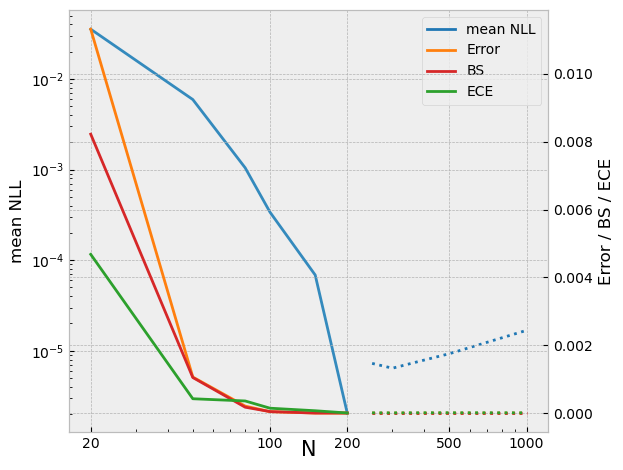

In [43]:
fig, ax1 = plt.subplots()

color_nll = 'tab:blue'
color_err = 'tab:orange'
color_bs = 'tab:red'
color_ece = 'tab:green'

ax1.set_xlabel('N', labelpad=-8, fontsize=15)
ax1.set_ylabel('mean NLL')#, color=color_nll)
ax1.plot(nll_means.keys(), nll_means.values(), label='NLL')#, color=color_nll)
ax1.plot(size_gen_nll_mean.keys(), size_gen_nll_mean.values(), linestyle='dotted', color=color_nll)
ax1.tick_params(axis='y')#, labelcolor=color_nll)

ax2 = ax1.twinx()
ax2.set_ylabel('Error / BS / ECE')
ax2.plot(error_means.keys(), error_means.values(), color=color_err, label='Error')
ax2.plot(bs_means.keys(), bs_means.values(), color=color_bs, label='BS')
ax2.plot(ece.keys(), ece.values(), color=color_ece, label='ECE')
#size gen
ax2.plot(size_gen_error_mean.keys(), size_gen_error_mean.values(), linestyle='dotted', color=color_err)
ax2.plot(size_gen_bs_mean.keys(), size_gen_bs_mean.values(), linestyle='dotted', color=color_bs)
ax2.plot(size_gen_ece.keys(), size_gen_ece.values(), linestyle='dotted', color=color_ece)
ax2.tick_params(axis='y')#, labelcolor=color)

fig.tight_layout()
# set log scale x axis
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')

# currently the xticklabels are too sparse, only at 100 and 1000. Lets include ticklabels at 20, 100, 200, 500, 1000
ax1.set_xticks([20, 100, 200, 500, 1000])
import matplotlib
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())



# Create a custom legend
legend_elements = [
    Line2D([0], [0], color=color_nll, lw=2, label='mean NLL'),
    #Line2D([0], [0], color=color_nll, lw=2, linestyle='dotted', label='NLL (size gen.)'),
    Line2D([0], [0], color=color_err, lw=2, label='Error'),
    #Line2D([0], [0], color=color_err, lw=2, linestyle='dotted', label='Error (size gen.)'),
    Line2D([0], [0], color=color_bs, lw=2, label='BS'),
    #Line2D([0], [0], color=color_bs, lw=2, linestyle='dotted', label='BS (size gen.)'),
    Line2D([0], [0], color=color_ece, lw=2, label='ECE'),
    #Line2D([0], [0], color=color_ece, linestyle='dashdot', lw=2, label='ECE (size gen.)'),
]
ax1.legend(handles=legend_elements, loc='upper right')
